Enter theta_0 for pendulum for all cases except notmal0.9
Enter Value of theta for normal case only0.9


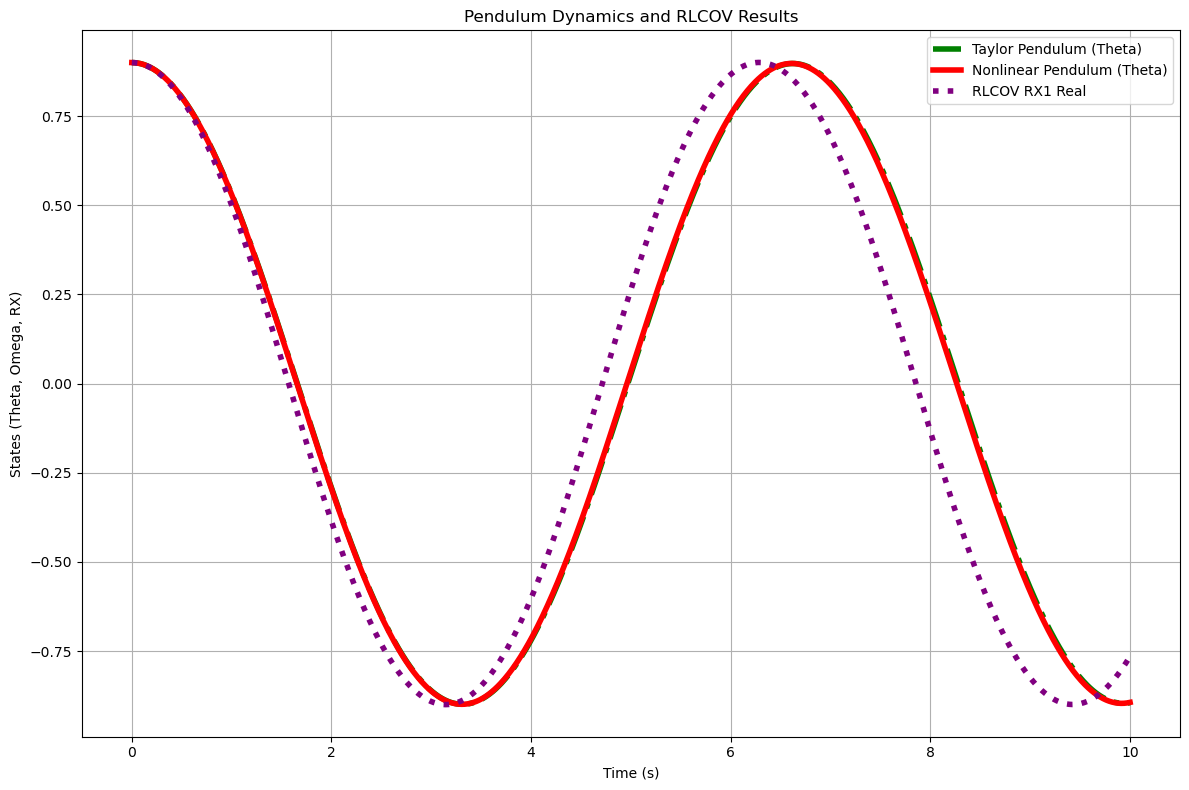

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from scipy.integrate import solve_ivp

# Define functions for pendulum dynamics
def linear_pendulum(t, state):
    theta, omega = state
    dtheta_dt = omega
    domega_dt = -theta
    return [dtheta_dt, domega_dt]

def pendulum_taylor(t, state):
    theta, omega = state
    dtheta_dt = omega
    domega_dt = -(theta - theta**3 / 6)
    return [dtheta_dt, domega_dt]

def pendulum(t, state):
    theta, omega = state
    dtheta_dt = omega
    domega_dt = -np.sin(theta)
    return [dtheta_dt, domega_dt]

# Define LCOV, RLCOV, h3, and RICOV functions
def LCOV(X, U):
    Ui = np.linalg.inv(U)
    return np.dot(Ui, X)

def RLCOV(RY, RU):
    RX = np.dot(RU, RY)
    return RX

def h3(z, h_coeffs):
    z1, z2 = z
    h3_z1 = (
        h_coeffs['h130'] * z1**3 +
        h_coeffs['h112'] * z1**2 * z2 +
        h_coeffs['h121'] * z1 * z2**2 +
        h_coeffs['h103'] * z2**3
    )
    h3_z2 = (
        h_coeffs['h230'] * z1**3 +
        h_coeffs['h212'] * z1**2 * z2 +
        h_coeffs['h221'] * z1 * z2**2 +
        h_coeffs['h203'] * z2**3
    )
    return np.array([h3_z1, h3_z2])

def RICOV(t, z):
    z1, z2 = z
    h3_values = h3([z1, z2], h_coeffs)
    y10 = z1 + h3_values[0]
    y20 = z2 + h3_values[1]
    return [y10, y20]

def compute_z_dot(t, z):
    z1, z2 = z
    h3_values = h3([z1, z2], h_coeffs)
    dz1_dt = 1j * (z1 + h3_values[0])
    dz2_dt = -1j * (z2 + h3_values[1])
    return [dz1_dt, dz2_dt]



################################# input here for other other cases #################################################################


theta_0 =float(input('Enter theta_0 for pendulum for all cases except notmal'))
omega_0 = 0.0
pendulum_state = [theta_0, omega_0]

# Time span for pendulum and RLCOV
t_span = (0, 10)
t_eval = np.linspace(0, 10, 1000)

# Solve pendulum systems
sol_linear = solve_ivp(linear_pendulum, t_span, pendulum_state, t_eval=t_eval)
sol_taylor = solve_ivp(pendulum_taylor, t_span, pendulum_state, t_eval=t_eval)
sol_nonlinear = solve_ivp(pendulum, t_span, pendulum_state, t_eval=t_eval)

# Initial conditions for RLCOV
h_coeffs = {
    'h130': -1/48, 'h112': 0, 'h121': 1/16, 'h103': 1/96,
    'h230': 1/96, 'h212': 1/16, 'h221': 0, 'h203': -1/48
}



#################################input here for the normal form#################################################################

A=float(input("Enter Value of theta for normal case only"))
X = np.array([[A], [0]])
U = (1 / np.sqrt(2)) * np.array([[1, 1], [1j, -1j]])
y = LCOV(X, U)
y_real_imag = np.concatenate([y.real.flatten(), y.imag.flatten()])
z0 = y_real_imag
z_solution_real_imag = fsolve(lambda z: np.concatenate(
    [(z[:2] + h3(z[:2] + 1j*z[2:], h_coeffs)).real - y[:2].real.flatten(),
     (z[:2] + h3(z[:2] + 1j*z[2:], h_coeffs)).imag - y[:2].imag.flatten()]), z0)
z_initial = z_solution_real_imag[:2] + 1j * z_solution_real_imag[2:]

# Solve RLCOV system
sol_rlcov = solve_ivp(compute_z_dot, t_span, z_initial, t_eval=t_eval)
ricov_results = [RICOV(t, z) for t, z in zip(sol_rlcov.t, sol_rlcov.y.T)]
RU = (1 / np.sqrt(2)) * np.array([[1, 1], [1j, -1j]])
rlcov_results = [RLCOV(np.array([y10, y20]), RU) for y10, y20 in ricov_results]
rlcov_results_array = np.array(rlcov_results)

# Plot results
plt.figure(figsize=(12, 8))

# Pendulum Dynamics
#plt.plot(sol_linear.t, sol_linear.y[0], label='Linear Pendulum (Theta)', linestyle='--', color='blue',linewidth=4)
#plt.plot(sol_linear.t, sol_linear.y[1], label='Linear Pendulum (Omega)', linestyle='--', color='cyan')
plt.plot(sol_taylor.t, sol_taylor.y[0], label='Taylor Pendulum (Theta)', linestyle='-.', color='green',linewidth=4)
#plt.plot(sol_taylor.t, sol_taylor.y[1], label='Taylor Pendulum (Omega)', linestyle='-.', color='lime')
plt.plot(sol_nonlinear.t, sol_nonlinear.y[0], label='Nonlinear Pendulum (Theta)', linestyle='-', color='red',linewidth=4)
#plt.plot(sol_nonlinear.t, sol_nonlinear.y[1], label='Nonlinear Pendulum (Omega)', linestyle='-', color='orange',linewidth=2)

# RLCOV Results
plt.plot(sol_rlcov.t, rlcov_results_array[:, 0].real, label='RLCOV RX1 Real', linestyle=':', color='purple',linewidth=4)
#plt.plot(sol_rlcov.t, rlcov_results_array[:, 0].imag, label='RLCOV RX1 Imag', linestyle=':', color='magenta')
#plt.plot(sol_rlcov.t, rlcov_results_array[:, 1].real, label='RLCOV RX2 Real', linestyle=':', color='brown',linewidth=4)
#plt.plot(sol_rlcov.t, rlcov_results_array[:, 1].imag, label='RLCOV RX2 Imag', linestyle=':', color='pink')

# Customize plot
plt.xlabel("Time (s)")
plt.ylabel("States (Theta, Omega, RX)")
plt.title("Pendulum Dynamics and RLCOV Results")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()